In [33]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________
import ERROR
import CONFIG
import DBPARSE
from ASYMMETRY import *
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
import CORRECTIONS
import CALCULATE
from joblib import Parallel, delayed
import importlib
#importlib.reload(ASYMMETRY)

In [34]:
muN=1.9103 #minus

In [35]:
import sys
import re

class Filter:
    def __init__(self):
        self.old_stderr = sys.stderr
        sys.stderr = self

    def write(self, message):
        # Change the pattern here to match the specific ROOT errors
        if not re.search(r"Error in <TList::Clear>:", message):
            self.old_stderr.write(message)

    def flush(self):
        pass

# Apply the filter
filter = Filter()



In [36]:
pas="1"
config="3"

# Cuts

In [37]:
W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Q2: {Q2}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

W2min: -0.5
W2max: 1.7
dxmin: -0.4
dxmax: 0.4
dymin: -0.5
dymax: 0.5
dybgmin: -1.3
dybgmax: 1.2
Q2: 6.83
Coin Min: 88 Coin Max: 100


In [38]:
cut="w2"
value=[W2min,W2max]
NUMBER=30

In [39]:
W2max/2

0.85

In [40]:
config="2"

W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")


NUMBER=70
#w2
cutw2="w2"
valuemaxw2=np.linspace(W2max*.5,W2max*1.5,NUMBER)
valueminw2=np.linspace(W2min,W2min,NUMBER)

valuew2=np.transpose(np.stack([valueminw2,valuemaxw2],axis=0))

#dy
cutdy="dy"
valuemaxdy=np.linspace(dymax*.5,dymax*1.5,NUMBER)
valuemindy=np.linspace(dymin*.5,dymin*1.5,NUMBER)
valuedy=np.transpose(np.stack([valuemindy,valuemaxdy],axis=0))

#dx
cutdx="dx"
valuemaxdx=np.linspace(dxmax*.5,dxmax*1.5,NUMBER)
valuemindx=np.linspace(dxmin*.5,dxmin*1.5,NUMBER)
valuedx=np.transpose(np.stack([valuemindx,valuemaxdx],axis=0))


# Calculate Raw Asymmetry, Fit dx and determine fA for bg,proton,accidentals- Calc Aphys

In [50]:
def Function_APHYSSENS(config,cut,value):
    import ROOT as r
    import math
    import array
    import os
    import sys
    import matplotlib.pyplot as plt
    import numpy as np
    
    #______________Add include directory_______________
    current_dir = os.getcwd()
    include_dir = os.path.join(current_dir, '../include')
    sys.path.insert(0, include_dir)
    #__________________________________________________
    import ERROR
    import CONFIG
    import DBPARSE
    import ASYMMETRY 
    import UTILITIES 
    from SIMFITS import DistributionFits
    from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
    import CALCULATE
    import CORRECTIONS
    from joblib import Parallel, delayed
    
    W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
    W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
    dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
    dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
    dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
    dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
    dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
    dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
    coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
    coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
    #____________Varying Cut__________________
    if cut=="w2":
        W2max=value[1]
        W2min=value[0]
    elif cut=="dy":
        dymax=value[1]
        dymin=value[0]
    elif cut=="dx":
        dxmax=value[1]
        dxmin=value[0]        
    elif cut=="coin":
        coinmin=value[1]
        coinmax=value[0]
    quasicut=[[coinmin,coinmax],[W2min,W2max],[dxmin,dxmax],[dymin,dymax]]
    
    dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
    dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
    lower_bound=dxmin
    upper_bound=dxmax
    Raw=ASYMMETRY.Function_ASYMMETRYSENS(config,cut,value)
    print("Raw Asymmetry Calculated")
    
    Fit=ASYMMETRY.Function_FITDXSENS(config,cut,value)
    print("dx Histogram Fit Completed")
    
    data,bg,totalFit,simp,simn=Fit
    bin_centers,bin_contents=bg
    numBG=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])
    bin_centers,bin_contents=totalFit
    numTotal=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])
    bin_centers,bin_contents=simp
    numP=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])
    
    accResult,bgResult,fp=CORRECTIONS.Function_ANALYZEROOTFILE(config,bg,simp,totalFit)
    print(f"AccResult: {accResult}")
    bin_centers,bin_contents=simn
    Y=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])
    TrueYield=Raw[3]
    print("f A combinations Determined")
    
    Phys=ASYMMETRY.Function_APHYS(config,pas,Raw,accResult,bgResult,fp)
    print("Aphys Calculated")
    
    weighted_A,weighted_A_E,fbackg,rawA,rawAE,totalSys,totalStat=Phys
    print('Returned: Aphys, Aphys_E, fbg, cut, cutvalue')
    R,RE=CALCULATE.Function_CALCGEN(config,weighted_A,weighted_A_E)
    
    print(f'Cuts: Coin{quasicut[0]} W2{quasicut[1]} dX{quasicut[2]} dY{quasicut[3]}')
    
    return weighted_A,weighted_A_E,fbackg,cut,value,Y,R,RE,rawA,rawAE,np.mean(Raw[1]),quasicut

In [51]:
#Results=Function_APHYSSENS(config,cut,value)

In [52]:
#Results[2]

In [53]:
#Raw
#print(Results[8])


In [54]:
#A_phys
#print(Results[0])


In [55]:
#rat
#print(Results[6]*muN)
#print(Results[7])

In [56]:
#1.200691023930045

# GEN2__________________________________________________________

In [65]:
config="2"

W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")


NUMBER=70
#w2
cutw2="w2"
valuemaxw2=np.linspace(W2max*.5,W2max*1.5,NUMBER)
valueminw2=np.linspace(W2min,W2min,NUMBER)

valuew2=np.transpose(np.stack([valueminw2,valuemaxw2],axis=0))

#dy
cutdy="dy"
valuemaxdy=np.linspace(dymax*.5,dymax*1.5,NUMBER)
valuemindy=np.linspace(dymin*.5,dymin*1.5,NUMBER)
valuedy=np.transpose(np.stack([valuemindy,valuemaxdy],axis=0))

#dx
cutdx="dx"
valuemaxdx=np.linspace(dxmax*.5,dxmax*1.5,NUMBER)
valuemindx=np.linspace(dxmin*.5,dxmin*1.5,NUMBER)
valuedx=np.transpose(np.stack([valuemindx,valuemaxdx],axis=0))

# W2

In [66]:
%%time
n_jobs = -1  # Use all available CPU cores
Results2w2 = Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutw2,val) for (val) in valuew2)

CPU times: user 628 ms, sys: 421 ms, total: 1.05 s
Wall time: 15min 37s


In [67]:
A_result_2w2=np.empty(0)
E_result_2w2=np.empty(0)
fbg_result_2w2=np.empty(0)
cut_result_2w2=np.empty(0)
w2_2=np.empty(0)
Y_2w2=np.empty(0)
R_2w2=np.empty(0)
RE_2w2=np.empty(0)
quasicut=[]
for i in range(0,len(Results2w2)):
    A_result_2w2=np.append(A_result_2w2,Results2w2[i][0])
    E_result_2w2=np.append(E_result_2w2,Results2w2[i][1])  
    fbg_result_2w2=np.append(fbg_result_2w2,Results2w2[i][2])
    cut_result_2w2=np.append(cut_result_2w2,Results2w2[i][3])
    w2_2=np.append(w2_2,Results2w2[i][4][1])
    Y_2w2=np.append(Y_2w2,Results2w2[i][5])
    R_2w2=np.append(R_2w2,Results2w2[i][6])
    RE_2w2=np.append(RE_2w2,Results2w2[i][7])
    quasicut.append(Results2w2[i][11])

In [68]:
RE_2w2

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.01893942, 0.01881368,
       0.01878778, 0.01876118, 0.01870771, 0.018767  , 0.0186528 ,
       0.01864595, 0.01859266, 0.01872098, 0.01870806, 0.01876626,
       0.01877447, 0.01880507, 0.01884592, 0.0189286 , 0.01901039,
       0.01906768, 0.0192089 , 0.01931116, 0.01934712, 0.01943133,
       0.0195114 , 0.01956316, 0.01966312, 0.01972744, 0.01972505,
       0.01978469, 0.01986263, 0.01989567, 0.01997079, 0.01999406,
       0.02002578, 0.02004862, 0.02008352, 0.02009908, 0.02009862,
       0.02011142, 0.02010259, 0.02009985, 0.02009992, 0.02009841,
       0.02009841, 0.02009841, 0.02009841, 0.02009841, 0.02009841])

In [69]:
abs(muN*RE_2w2)

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.03617998, 0.03593977,
       0.0358903 , 0.03583949, 0.03573734, 0.0358506 , 0.03563245,
       0.03561935, 0.03551756, 0.03576268, 0.03573801, 0.03584919,
       0.03586487, 0.03592333, 0.03600137, 0.0361593 , 0.03631556,
       0.03642498, 0.03669477, 0.03689011, 0.0369588 , 0.03711968,
       0.03727263, 0.0373715 , 0.03756245, 0.03768532, 0.03768076,
       0.03779469, 0.03794358, 0.0380067 , 0.0381502 , 0.03819465,
       0.03825525, 0.03829887, 0.03836554, 0.03839528, 0.0383944 ,
       0.03841885, 0.03840197, 0.03839674, 0.03839688, 0.03839399,
       0.03839399, 0.03839399, 0.03839399, 0.03839399, 0.03839399])

In [70]:
quasicut

[[[95, 106], [0.0, 0.75], [-0.481, 0.498], [-0.822, 0.8]],
 [[95, 106], [0.0, 0.7717391304347826], [-0.481, 0.498], [-0.822, 0.8]],
 [[95, 106], [0.0, 0.7934782608695652], [-0.481, 0.498], [-0.822, 0.8]],
 [[95, 106], [0.0, 0.8152173913043478], [-0.481, 0.498], [-0.822, 0.8]],
 [[95, 106], [0.0, 0.8369565217391304], [-0.481, 0.498], [-0.822, 0.8]],
 [[95, 106], [0.0, 0.8586956521739131], [-0.481, 0.498], [-0.822, 0.8]],
 [[95, 106], [0.0, 0.8804347826086957], [-0.481, 0.498], [-0.822, 0.8]],
 [[95, 106], [0.0, 0.9021739130434783], [-0.481, 0.498], [-0.822, 0.8]],
 [[95, 106], [0.0, 0.9239130434782609], [-0.481, 0.498], [-0.822, 0.8]],
 [[95, 106], [0.0, 0.9456521739130435], [-0.481, 0.498], [-0.822, 0.8]],
 [[95, 106], [0.0, 0.967391304347826], [-0.481, 0.498], [-0.822, 0.8]],
 [[95, 106], [0.0, 0.9891304347826086], [-0.481, 0.498], [-0.822, 0.8]],
 [[95, 106], [0.0, 1.0108695652173914], [-0.481, 0.498], [-0.822, 0.8]],
 [[95, 106], [0.0, 1.0326086956521738], [-0.481, 0.498], [-0.822, 

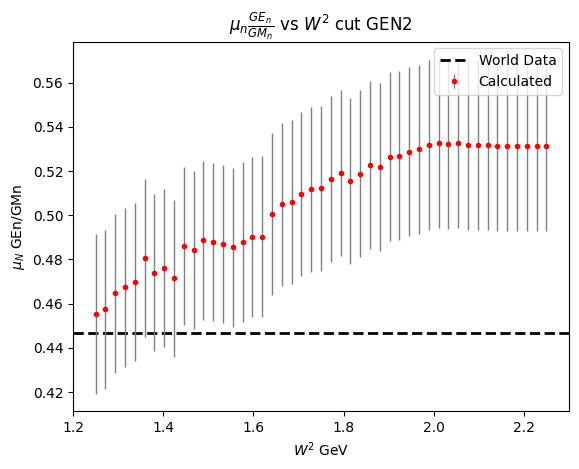

In [71]:
config="2"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(w2_2,abs(muN*R_2w2),abs(muN*RE_2w2),fmt='.',ecolor='grey',color='red',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $W^2$ cut GEN'+config)
plt.xlabel("$W^2$ GeV")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_w2.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_w2.npy', {
    'R': 2*abs(R_2w2),
    'RE': 2*abs(RE_2w2),
    'cut': w2_2,
},allow_pickle=True)


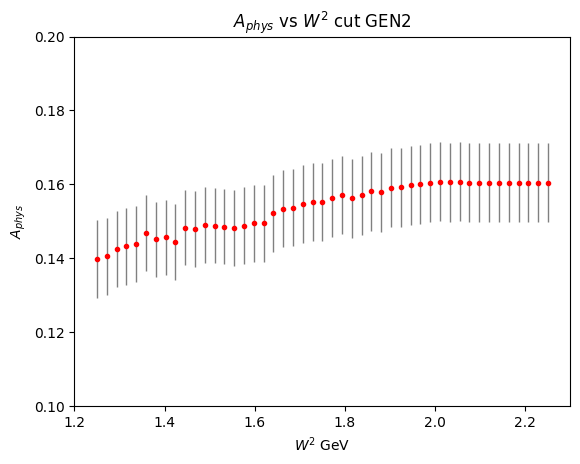

In [72]:

config="2"
plt.errorbar(w2_2,A_result_2w2,E_result_2w2,fmt='.',ecolor='grey',color='red',lw=1)
#plt.plot(w2_2,Y_2)
#plt.yscale('log')
plt.ylim(.1,.2)
plt.title("$A_{phys}$ vs $W^2$ cut GEN"+config)
plt.xlabel("$W^2$ GeV")
plt.ylabel("$A_{phys}$")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_w2.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/APHYS_w2.npy', {
    'A': A_result_2w2,
    'AE': E_result_2w2,
    'cut': w2_2,
},allow_pickle=True)

# dY

In [73]:
%%time
n_jobs = -1  # Use all available CPU cores
Results2dy = Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutdy,val) for (val) in valuedy)

CPU times: user 642 ms, sys: 503 ms, total: 1.14 s
Wall time: 15min 41s


In [74]:
A_result_2dy=np.empty(0)
E_result_2dy=np.empty(0)
fbg_result_2dy=np.empty(0)
cut_result_2dy=np.empty(0)
dy_2=np.empty(0)
Y_2dy=np.empty(0)
R_2dy=np.empty(0)
RE_2dy=np.empty(0)

for i in range(0,len(Results2dy)):
    A_result_2dy=np.append(A_result_2dy,Results2dy[i][0])
    E_result_2dy=np.append(E_result_2dy,Results2dy[i][1])  
    fbg_result_2dy=np.append(fbg_result_2dy,Results2dy[i][2])
    cut_result_2dy=np.append(cut_result_2dy,Results2dy[i][3])
    dy_2=np.append(dy_2,Results2dy[i][4][1])
    Y_2dy=np.append(Y_2dy,Results2dy[i][5])
    R_2dy=np.append(R_2dy,Results2dy[i][6])
    RE_2dy=np.append(RE_2dy,Results2dy[i][7])

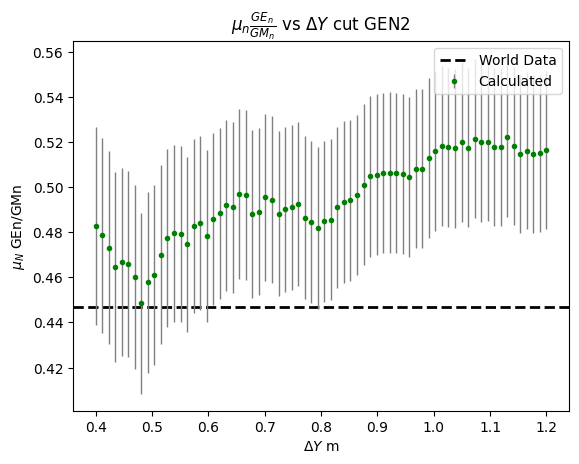

In [75]:
config="2"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(dy_2,abs(R_2dy*muN),abs(muN*RE_2dy),fmt='.',ecolor='grey',color='green',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $\Delta Y$ cut GEN'+config)
plt.xlabel("$\Delta Y$ m")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_dy.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_dy.npy', {
    'R': 2*abs(R_2dy),
    'RE': 2*abs(RE_2dy),
    'cut': w2_2,
},allow_pickle=True)


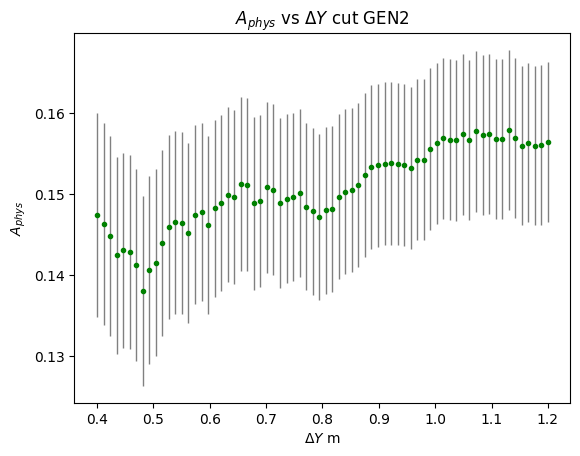

In [76]:
config="2"
plt.errorbar(dy_2,A_result_2dy,E_result_2dy,fmt='.',ecolor='grey',color='green',lw=1)
plt.title("$A_{phys}$ vs $\Delta Y$ cut GEN"+config)
plt.xlabel("$\Delta Y$ m")
plt.ylabel("$A_{phys}$")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_dy.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/APHYS_dy.npy', {
    'A': A_result_2dy,
    'AE': E_result_2dy,
    'cut': dy_2,
},allow_pickle=True)

# dx

In [77]:
%%time
n_jobs = -1  # Use all available CPU cores
Results2dx = Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutdx,val) for (val) in valuedx)

CPU times: user 558 ms, sys: 436 ms, total: 993 ms
Wall time: 15min 37s


In [78]:
A_result_2dx=np.empty(0)
E_result_2dx=np.empty(0)
fbg_result_2dx=np.empty(0)
cut_result_2dx=np.empty(0)
dx_2=np.empty(0)
Y_2dx=np.empty(0)
R_2dx=np.empty(0)
RE_2dx=np.empty(0)

for i in range(0,len(Results2dx)):
    A_result_2dx=np.append(A_result_2dx,Results2dx[i][0])
    E_result_2dx=np.append(E_result_2dx,Results2dx[i][1])  
    fbg_result_2dx=np.append(fbg_result_2dx,Results2dx[i][2])
    cut_result_2dx=np.append(cut_result_2dx,Results2dx[i][3])
    dx_2=np.append(dx_2,Results2dx[i][4][1])
    Y_2dx=np.append(Y_2dx,Results2dx[i][5])
    R_2dx=np.append(R_2dx,Results2dx[i][6])
    RE_2dx=np.append(RE_2dx,Results2dx[i][7])

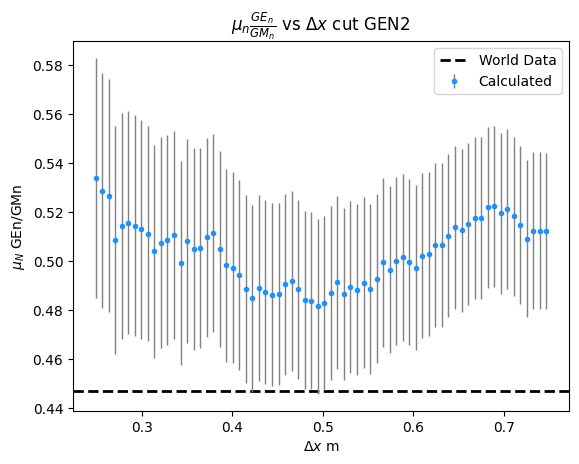

In [79]:
config="2"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(dx_2,abs(muN*R_2dx),abs(muN*RE_2dx),fmt='.',ecolor='grey',color='dodgerblue',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $\Delta x$ cut GEN'+config)
plt.xlabel("$\Delta x$ m")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_dx.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_dx.npy', {
    'R': 2*abs(R_2dx),
    'RE': 2*abs(RE_2dx),
    'cut': dx_2,
},allow_pickle=True)

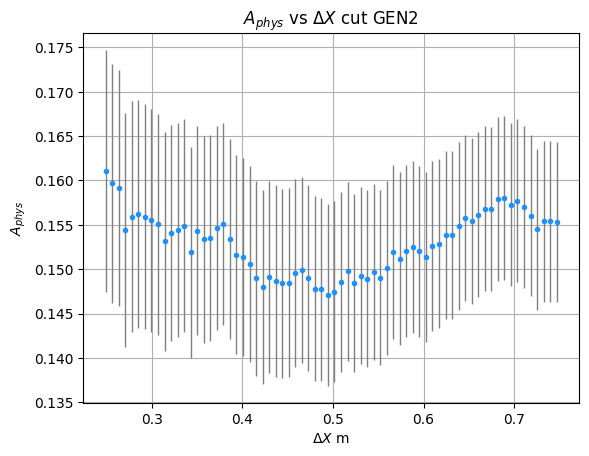

In [80]:
config="2"
plt.errorbar(dx_2,A_result_2dx,E_result_2dx,fmt='.',ecolor='grey',color='dodgerblue',lw=1)
plt.title("$A_{phys}$ vs $\Delta X$ cut GEN"+config)
plt.xlabel("$\Delta X$ m")
plt.grid()
plt.ylabel("$A_{phys}$")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_dx.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/APHYS_dx.npy', {
    'A': A_result_2dx,
    'AE': E_result_2dx,
    'cut': dx_2,
},allow_pickle=True)

In [86]:
RE_2dx

array([0.02562878, 0.02522335, 0.02488425, 0.02434779, 0.02415501,
       0.02389671, 0.02362198, 0.02335004, 0.0230839 , 0.02277314,
       0.02260358, 0.02240308, 0.02221869, 0.02188019, 0.02179505,
       0.02157008, 0.0213956 , 0.0212725 , 0.02111923, 0.02088151,
       0.02065446, 0.02049774, 0.02031815, 0.0201142 , 0.01993587,
       0.01985136, 0.0197083 , 0.01957191, 0.01945364, 0.01937724,
       0.01927204, 0.01913037, 0.01897497, 0.01887125, 0.01874833,
       0.01866535, 0.01861184, 0.01855774, 0.01841703, 0.01835914,
       0.01825908, 0.01820544, 0.01809954, 0.01805786, 0.0180472 ,
       0.01794533, 0.01790234, 0.01784199, 0.01775658, 0.01766683,
       0.01764255, 0.01758724, 0.01755685, 0.01749653, 0.01747146,
       0.01744297, 0.01737002, 0.01733853, 0.01730685, 0.01725011,
       0.01723769, 0.01718762, 0.01711004, 0.01707595, 0.0169975 ,
       0.0169136 , 0.01681107, 0.01679854, 0.01675292, 0.01670702])

# GEN3___________________________________________________________

In [81]:
config="3"

W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")


NUMBER=70
#w2
cutw2="w2"
valuemaxw2=np.linspace(W2max*.5,W2max*1.5,NUMBER)
valueminw2=np.linspace(W2min,W2min,NUMBER)

valuew2=np.transpose(np.stack([valueminw2,valuemaxw2],axis=0))

#dy
cutdy="dy"
valuemaxdy=np.linspace(dymax*.5,dymax*1.5,NUMBER)
valuemindy=np.linspace(dymin*.5,dymin*1.5,NUMBER)
valuedy=np.transpose(np.stack([valuemindy,valuemaxdy],axis=0))

#dx
cutdx="dx"
valuemaxdx=np.linspace(dxmax*.5,dxmax*1.5,NUMBER)
valuemindx=np.linspace(dxmin*.5,dxmin*1.5,NUMBER)
valuedx=np.transpose(np.stack([valuemindx,valuemaxdx],axis=0))

# W2

In [87]:
%%time
pas="1"
n_jobs = -1  # Use all available CPU cores
Results3 = Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutw2,val) for (val) in valuew2)



CPU times: user 703 ms, sys: 536 ms, total: 1.24 s
Wall time: 15min 55s


In [88]:
A_result_3=np.empty(0)
E_result_3=np.empty(0)
Araw_result_3=np.empty(0)
Eraw_result_3=np.empty(0)

fbg_result_3=np.empty(0)
cut_result_3=np.empty(0)
w2_3=np.empty(0)
Y_3=np.empty(0)
R_3w2=np.empty(0)
RE_3w2=np.empty(0)

for i in range(0,len(Results3)):
    A_result_3=np.append(A_result_3,Results3[i][0])
    E_result_3=np.append(E_result_3,Results3[i][1])  
    Araw_result_3=np.append(Araw_result_3,Results3[i][8])
    Eraw_result_3=np.append(Eraw_result_3,Results3[i][9])  
    fbg_result_3=np.append(fbg_result_3,Results3[i][2])
    cut_result_3=np.append(cut_result_3,Results3[i][3])
    w2_3=np.append(w2_3,Results3[i][4][1])
    Y_3=np.append(Y_3,Results3[i][5])
    R_3w2=np.append(R_3w2,Results3[i][6])
    RE_3w2=np.append(RE_3w2,Results3[i][7])

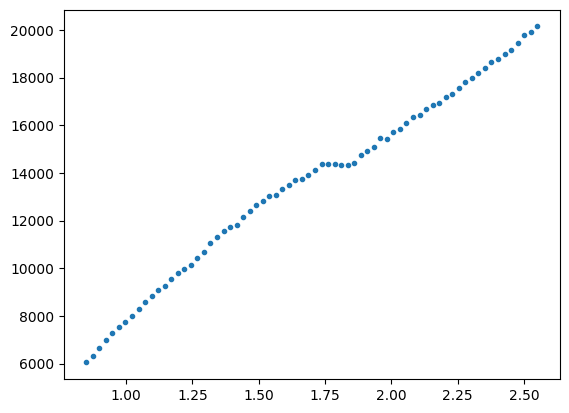

In [89]:
plt.plot(w2_3,Y_3,'.')

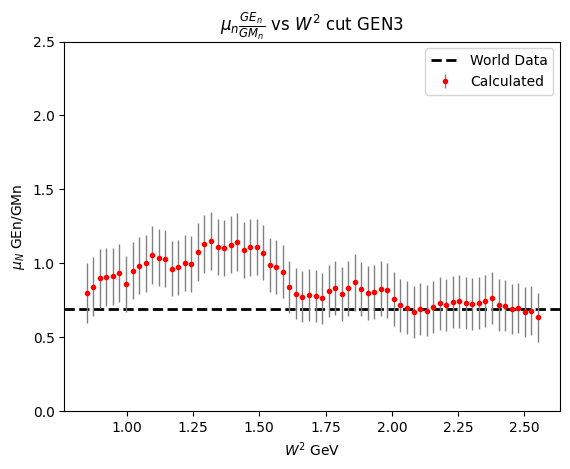

In [90]:
config="3"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(w2_3,abs(muN*R_3w2),abs(muN*RE_3w2),fmt='.',ecolor='grey',color='red',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $W^2$ cut GEN'+config)
plt.xlabel("$W^2$ GeV")
plt.ylim(0,2.5)
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_w2.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_w2.npy', {
    'R': 2*abs(R_3w2),
    'RE': 2*abs(RE_3w2),
    'cut': w2_3,
},allow_pickle=True)

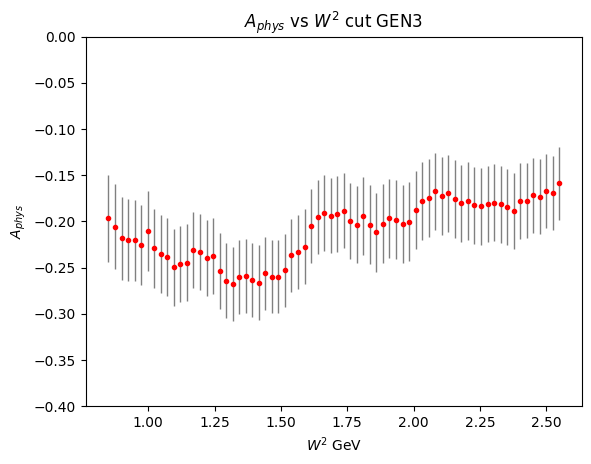

In [91]:
config="3"
plt.errorbar(w2_3,A_result_3,E_result_3,fmt='.',ecolor='grey',color='red',lw=1)
plt.ylim(-.4,0)
plt.title("$A_{phys}$ vs $W^2$ cut GEN"+config)
plt.xlabel("$W^2$ GeV")
plt.ylabel("$A_{phys}$")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_w2.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/APHYS_w2.npy', {
    'A': A_result_3,
    'AE': E_result_3,
    'cut': w2_3,
},allow_pickle=True)

Text(0, 0.5, '$A_{raw}$')

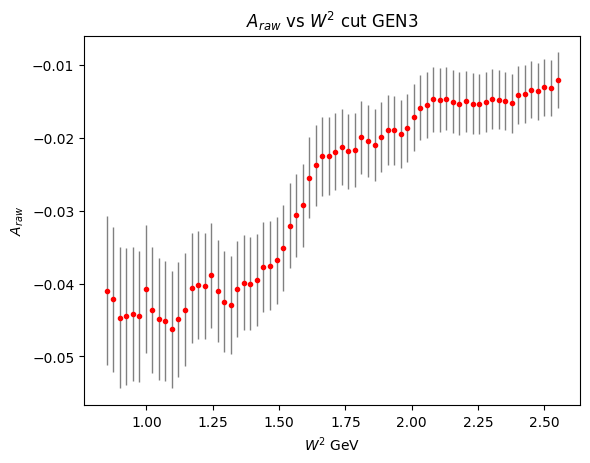

In [92]:
config="3"
plt.errorbar(w2_3,Araw_result_3,Eraw_result_3,fmt='.',ecolor='grey',color='red',lw=1)
#plt.ylim(-.4,0)
plt.title("$A_{raw}$ vs $W^2$ cut GEN"+config)
plt.xlabel("$W^2$ GeV")
plt.ylabel("$A_{raw}$")


# dy

In [93]:
%%time
n_jobs = -1  # Use all available CPU cores
Results3dy = Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutdy,val) for (val) in valuedy)

CPU times: user 620 ms, sys: 523 ms, total: 1.14 s
Wall time: 15min 50s


In [94]:
A_result_3dy=np.empty(0)
E_result_3dy=np.empty(0)
fbg_result_3dy=np.empty(0)
cut_result_3dy=np.empty(0)
dy_3=np.empty(0)
Y_3dy=np.empty(0)
R_3dy=np.empty(0)
RE_3dy=np.empty(0)

for i in range(0,len(Results3dy)):
    A_result_3dy=np.append(A_result_3dy,Results3dy[i][0])
    E_result_3dy=np.append(E_result_3dy,Results3dy[i][1])  
    fbg_result_3dy=np.append(fbg_result_3dy,Results3dy[i][2])
    cut_result_3dy=np.append(cut_result_3dy,Results3dy[i][3])
    dy_3=np.append(dy_3,Results3dy[i][4][1])
    Y_3dy=np.append(Y_3dy,Results3dy[i][5])
    R_3dy=np.append(R_3dy,Results3dy[i][6])
    RE_3dy=np.append(RE_3dy,Results3dy[i][7])

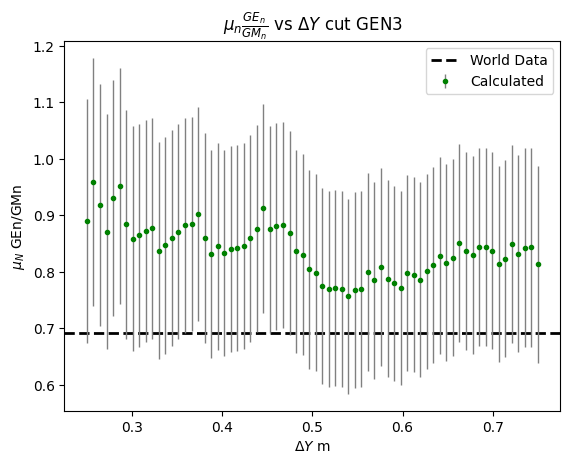

In [95]:
config="3"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(dy_3,abs(muN*R_3dy),abs(muN*RE_3dy),fmt='.',ecolor='grey',color='green',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $\Delta Y$ cut GEN'+config)
plt.xlabel("$\Delta Y$ m")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_dy.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_dy.npy', {
    'R': 2*abs(R_3dy),
    'RE': 2*abs(RE_3dy),
    'cut': dy_3,
},allow_pickle=True)


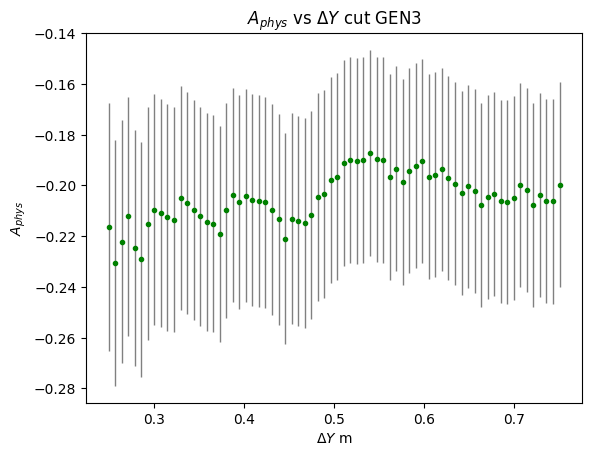

In [96]:
config="3"
plt.errorbar(dy_3,A_result_3dy,E_result_3dy,fmt='.',ecolor='grey',color='green',lw=1)
plt.title("$A_{phys}$ vs $\Delta Y$ cut GEN"+config)
plt.xlabel("$\Delta Y$ m")
plt.ylabel("$A_{phys}$")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_dy.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/APHYS_dy.npy', {
    'A': A_result_3dy,
    'AE': E_result_3dy,
    'cut': dy_3,
},allow_pickle=True)

# dx

In [97]:
%%time
n_jobs = -1  # Use all available CPU cores
Results3dx = Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutdx,val) for (val) in valuedx)

CPU times: user 640 ms, sys: 501 ms, total: 1.14 s
Wall time: 15min 38s


In [98]:
A_result_3dx=np.empty(0)
E_result_3dx=np.empty(0)
fbg_result_3dx=np.empty(0)
cut_result_3dx=np.empty(0)
dx_3=np.empty(0)
Y_3dx=np.empty(0)
R_3dx=np.empty(0)
RE_3dx=np.empty(0)

for i in range(0,len(Results3dx)):
    A_result_3dx=np.append(A_result_3dx,Results3dx[i][0])
    E_result_3dx=np.append(E_result_3dx,Results3dx[i][1])  
    fbg_result_3dx=np.append(fbg_result_3dx,Results3dx[i][2])
    cut_result_3dx=np.append(cut_result_3dx,Results3dx[i][3])
    dx_3=np.append(dx_3,Results3dx[i][4][1])
    Y_3dx=np.append(Y_3dx,Results3dx[i][5])
    R_3dx=np.append(R_3dx,Results3dx[i][6])
    RE_3dx=np.append(RE_3dx,Results3dx[i][7])

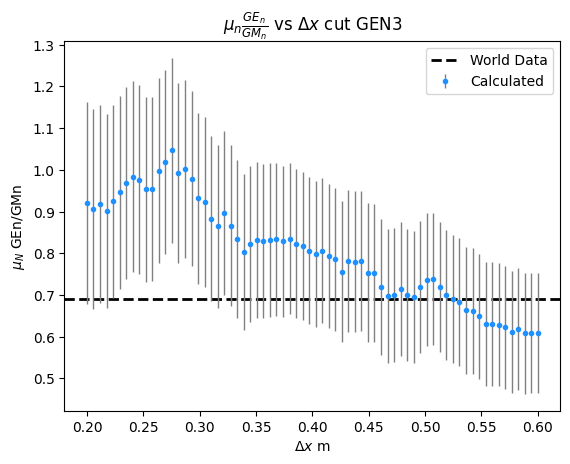

In [99]:
config="3"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(dx_3,abs(muN*R_3dx),abs(muN*RE_3dx),fmt='.',ecolor='grey',color='dodgerblue',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $\Delta x$ cut GEN'+config)
plt.xlabel("$\Delta x$ m")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_dx.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_dx.npy', {
    'R': 2*abs(R_3dx),
    'RE': 2*abs(RE_3dx),
    'cut': dx_3,
},allow_pickle=True)

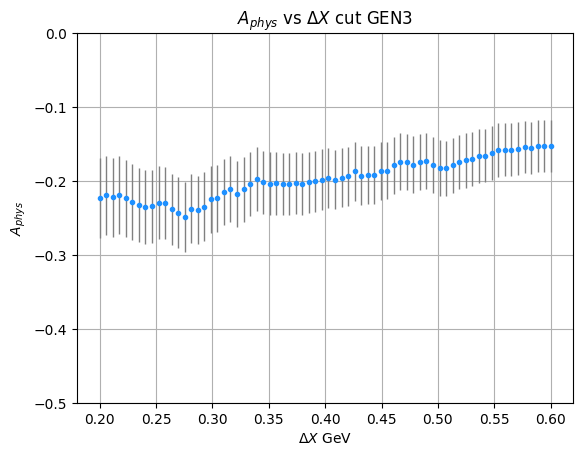

In [100]:
config="3"
plt.errorbar(dx_3,A_result_3dx,E_result_3dx,fmt='.',ecolor='grey',color='dodgerblue',lw=1)
plt.title("$A_{phys}$ vs $\Delta X$ cut GEN"+config)
plt.xlabel("$\Delta X$ GeV")
plt.ylabel("$A_{phys}$")
plt.ylim(-.5,0)
plt.grid()
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_dx.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/APHYS_dx.npy', {
    'A': A_result_3dx,
    'AE': E_result_3dx,
    'cut': dx_3,
},allow_pickle=True)

# GEN4

# W2

In [101]:
config="4"

W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")


NUMBER=70
#w2
cutw2="w2"
valuemaxw2=np.linspace(W2max*.5,W2max*1.5,NUMBER)
valueminw2=np.linspace(W2min,W2min,NUMBER)

valuew2=np.transpose(np.stack([valueminw2,valuemaxw2],axis=0))

#dy
cutdy="dy"
valuemaxdy=np.linspace(dymax*.5,dymax*1.5,NUMBER)
valuemindy=np.linspace(dymin*.5,dymin*1.5,NUMBER)
valuedy=np.transpose(np.stack([valuemindy,valuemaxdy],axis=0))

#dx
cutdx="dx"
valuemaxdx=np.linspace(dxmax*.5,dxmax*1.5,NUMBER)
valuemindx=np.linspace(dxmin*.5,dxmin*1.5,NUMBER)
valuedx=np.transpose(np.stack([valuemindx,valuemaxdx],axis=0))

In [104]:
%%time
pas="1"
n_jobs = -1  # Use all available CPU cores
Results4= Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutw2,val) for (val) in valuew2)

CPU times: user 289 ms, sys: 254 ms, total: 543 ms
Wall time: 5min 13s


In [105]:
A_result_4=np.empty(0)
E_result_4=np.empty(0)
fbg_result_4=np.empty(0)
cut_result_4=np.empty(0)
w2_4=np.empty(0)
Y_4=np.empty(0)
R_4w2=np.empty(0)
RE_4w2=np.empty(0)

for i in range(0,len(Results4)):
    A_result_4=np.append(A_result_4,Results4[i][0])
    E_result_4=np.append(E_result_4,Results4[i][1])  
    fbg_result_4=np.append(fbg_result_4,Results4[i][2])
    cut_result_4=np.append(cut_result_4,Results4[i][3])
    w2_4=np.append(w2_4,Results4[i][4][1])
    Y_4=np.append(Y_4,Results4[i][5])
    R_4w2=np.append(R_4w2,Results4[i][6])
    RE_4w2=np.append(RE_4w2,Results4[i][7])

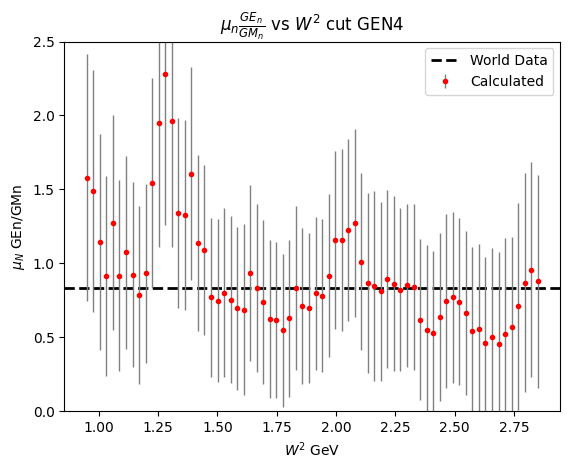

In [106]:
config="4"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(w2_4,abs(muN*R_4w2),abs(muN*RE_4w2),fmt='.',ecolor='grey',color='red',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $W^2$ cut GEN'+config)
plt.xlabel("$W^2$ GeV")
plt.ylim(0,2.5)
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_w2.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_w2.npy', {
    'R': 2*abs(R_4w2),
    'RE': 2*abs(RE_4w2),
    'cut': w2_4,
},allow_pickle=True)

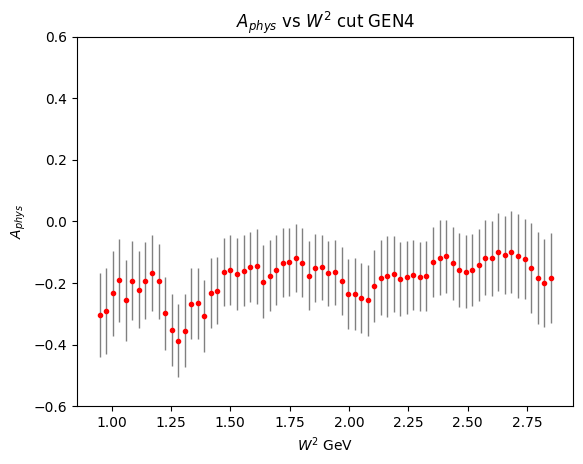

In [107]:
config="4"
plt.errorbar(w2_4,A_result_4,E_result_4,fmt='.',ecolor='grey',color='red',lw=1)
plt.title("$A_{phys}$ vs $W^2$ cut GEN"+config)
plt.xlabel("$W^2$ GeV")
plt.ylabel("$A_{phys}$")
plt.ylim(-.6,.6)
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_w2.png")

# dy

In [108]:
%%time
n_jobs = -1  # Use all available CPU cores
Results4dy = Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutdy,val) for (val) in valuedy)

CPU times: user 267 ms, sys: 136 ms, total: 403 ms
Wall time: 5min 15s


In [109]:
A_result_4dy=np.empty(0)
E_result_4dy=np.empty(0)
fbg_result_4dy=np.empty(0)
cut_result_4dy=np.empty(0)
dy_4=np.empty(0)
Y_4dy=np.empty(0)
R_4dy=np.empty(0)
RE_4dy=np.empty(0)

for i in range(0,len(Results4dy)):
    A_result_4dy=np.append(A_result_4dy,Results4dy[i][0])
    E_result_4dy=np.append(E_result_4dy,Results4dy[i][1])  
    fbg_result_4dy=np.append(fbg_result_4dy,Results4dy[i][2])
    cut_result_4dy=np.append(cut_result_4dy,Results4dy[i][3])
    dy_4=np.append(dy_4,Results4dy[i][4][1])
    Y_4dy=np.append(Y_4dy,Results4dy[i][5])
    R_4dy=np.append(R_4dy,Results4dy[i][6])
    RE_4dy=np.append(RE_4dy,Results4dy[i][7])

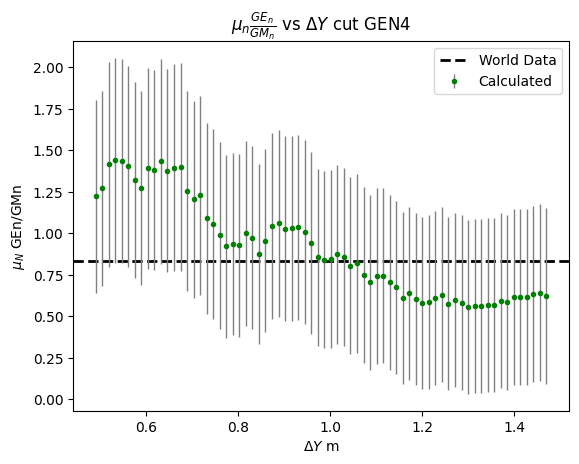

In [110]:
config="4"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(dy_4,abs(muN*R_4dy),abs(muN*RE_4dy),fmt='.',ecolor='grey',color='green',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $\Delta Y$ cut GEN'+config)
plt.xlabel("$\Delta Y$ m")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_dy.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_dy.npy', {
    'R': 2*abs(R_4dy),
    'RE': 2*abs(RE_4dy),
    'cut': dy_4,
},allow_pickle=True)

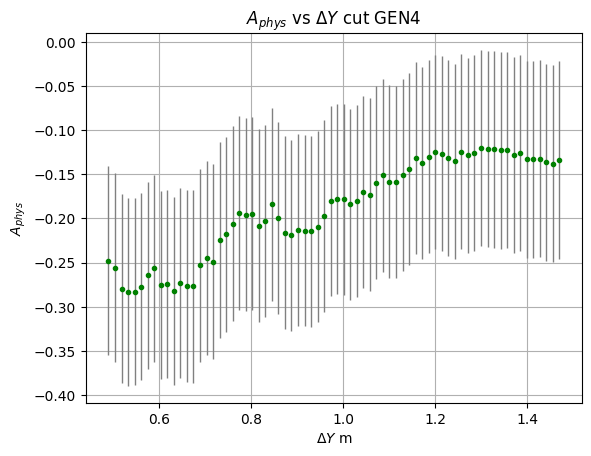

In [111]:
config="4"
plt.errorbar(dy_4,A_result_4dy,E_result_4dy,fmt='.',ecolor='grey',color='green',lw=1)
plt.title("$A_{phys}$ vs $\Delta Y$ cut GEN"+config)
plt.xlabel("$\Delta Y$ m")
plt.ylabel("$A_{phys}$")
#plt.ylim(0,.6)
plt.grid()
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_dy.png")

# dx

In [112]:
%%time
n_jobs = -1  # Use all available CPU cores
Results4dx = Parallel(n_jobs=n_jobs)(delayed(Function_APHYSSENS)(config,cutdx,val) for (val) in valuedx)

CPU times: user 334 ms, sys: 130 ms, total: 464 ms
Wall time: 5min 12s


In [113]:
A_result_4dx=np.empty(0)
E_result_4dx=np.empty(0)
fbg_result_4dx=np.empty(0)
cut_result_4dx=np.empty(0)
dx_4=np.empty(0)
Y_4dx=np.empty(0)
R_4dx=np.empty(0)
RE_4dx=np.empty(0)

for i in range(0,len(Results4dx)):
    A_result_4dx=np.append(A_result_4dx,Results4dx[i][0])
    E_result_4dx=np.append(E_result_4dx,Results4dx[i][1])  
    fbg_result_4dx=np.append(fbg_result_4dx,Results4dx[i][2])
    cut_result_4dx=np.append(cut_result_4dx,Results4dx[i][3])
    dx_4=np.append(dx_4,Results4dx[i][4][1])
    Y_4dx=np.append(Y_4dx,Results4dx[i][5])
    R_4dx=np.append(R_4dx,Results4dx[i][6])
    RE_4dx=np.append(RE_4dx,Results4dx[i][7])

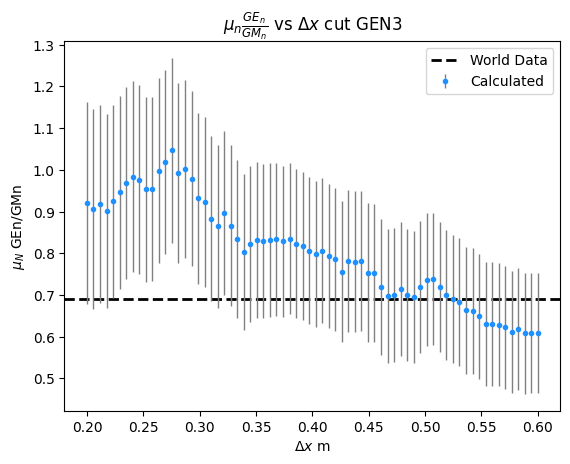

In [114]:
config="3"

Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='World Data')
plt.errorbar(dx_3,abs(muN*R_3dx),abs(muN*RE_3dx),fmt='.',ecolor='grey',color='dodgerblue',lw=1,label='Calculated')

plt.title(r'$\mu_n\frac{GE_n}{GM_n}$ vs $\Delta x$ cut GEN'+config)
plt.xlabel("$\Delta x$ m")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.legend(loc="upper right")
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RatGEN_dx.png")
np.save(f'CutSensPhysArrays/Pass{pas}/GEN{config}/RatGEN_dx.npy', {
    'R': 2*abs(R_3dx),
    'RE': 2*abs(RE_3dx),
    'cut': dx_3,
},allow_pickle=True)

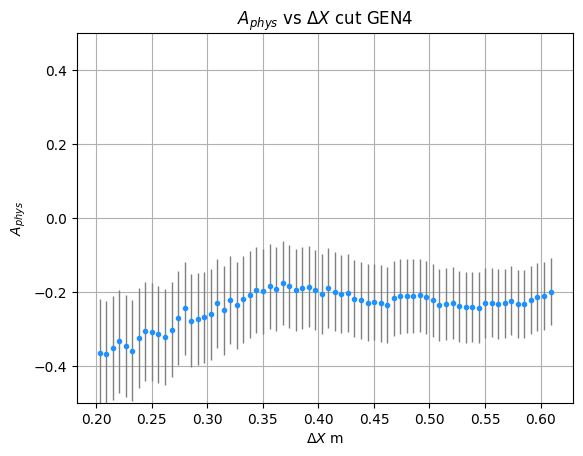

In [115]:
config="4"
plt.errorbar(dx_4,A_result_4dx,E_result_4dx,fmt='.',ecolor='grey',color='dodgerblue',lw=1)
plt.title("$A_{phys}$ vs $\Delta X$ cut GEN"+config)
plt.xlabel("$\Delta X$ m")
plt.ylabel("$A_{phys}$")
plt.ylim(-.5,.5)
plt.grid()
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/APHYS_dx.png")

# Nice Plotting

In [116]:
from DXDYW2COIN import *

# GEN2 Plots

In [117]:
config="2"

dxHist2,dyHist2,w2Hist2=Function_MAKEHIST(config)

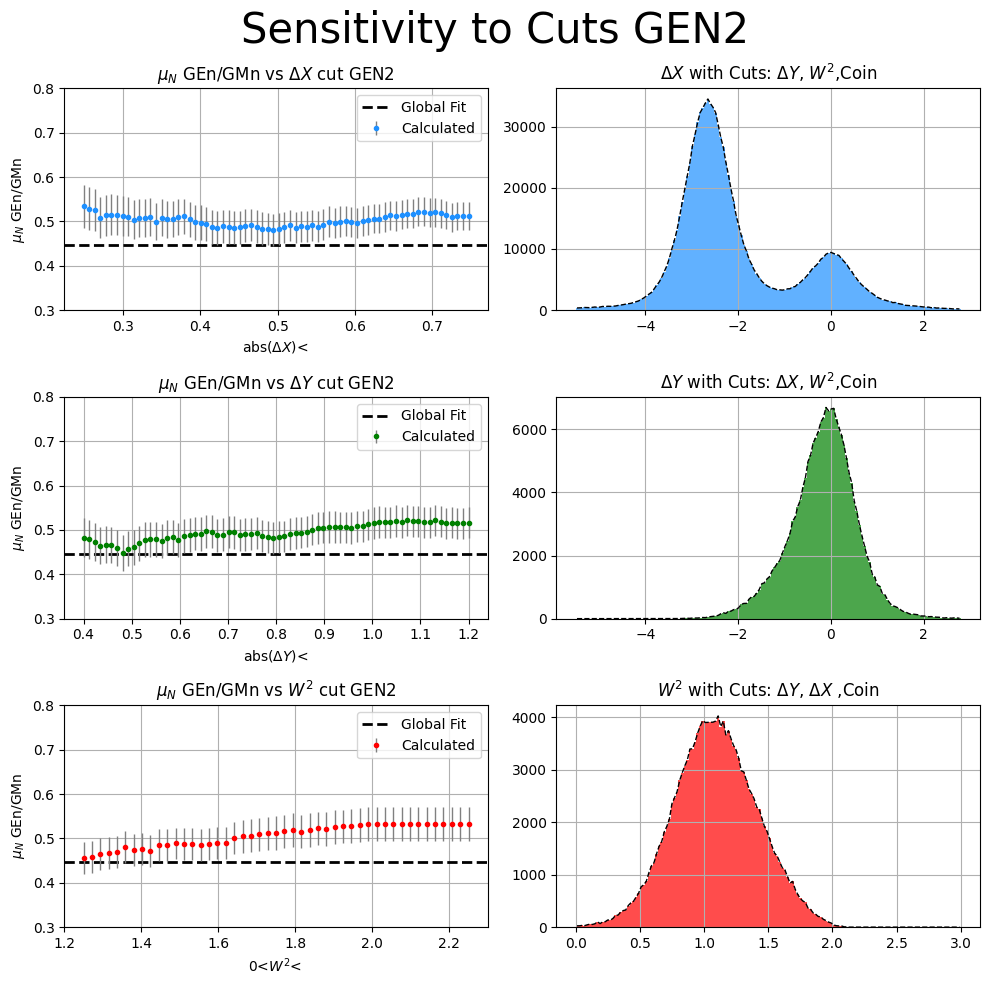

In [118]:
config="2"
lw=1
plt.figure(figsize=(10,10))
plt.suptitle('Sensitivity to Cuts GEN2', fontsize=30)

plt.subplot(3,2,1)
Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')
plt.errorbar(dx_2,muN*abs(R_2dx),muN*abs(RE_2dx),fmt='.',ecolor='grey',color='dodgerblue',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $\Delta X$ cut GEN"+config)
plt.xlabel("abs($\Delta X$)< ")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(.3,.8)
plt.grid()
plt.legend(loc="upper right")

plt.subplot(3,2,3)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')

plt.errorbar(dy_2,muN*abs(R_2dy),muN*abs(RE_2dy),fmt='.',ecolor='grey',color='green',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $\Delta Y$ cut GEN"+config)
plt.xlabel("abs($\Delta Y$)<")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(.3,.8)
plt.grid()
plt.legend(loc="upper right")

plt.subplot(3,2,5)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')
plt.grid()
plt.errorbar(w2_2,muN*abs(R_2w2),muN*abs(RE_2w2),fmt='.',ecolor='grey',color='red',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $W^2$ cut GEN"+config)
plt.xlabel("0<$W^2$< ")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(.3,.8)
plt.legend(loc="upper right")

plt.subplot(3,2,2)
plt.title("$\Delta X$ with Cuts: $\Delta Y$, $W^2$,Coin")
bin_centers,bin_contents=dxHist2
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="dodgerblue",label="$\Delta X$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()
plt.subplot(3,2,4)
plt.title("$\Delta Y$ with Cuts: $\Delta X$, $W^2$,Coin")
bin_centers,bin_contents=dyHist2
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="green",label="$\Delta Y$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()
plt.subplot(3,2,6)
plt.title("$W^2$ with Cuts: $\Delta Y$, $\Delta X$ ,Coin")
bin_centers,bin_contents=w2Hist2
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="red",label="$\Delta Y$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()

plt.tight_layout()
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RAT_allcuts.png")


# GEN3 Plots

In [119]:
config="3"

dxHist3,dyHist3,w2Hist3=Function_MAKEHIST(config)

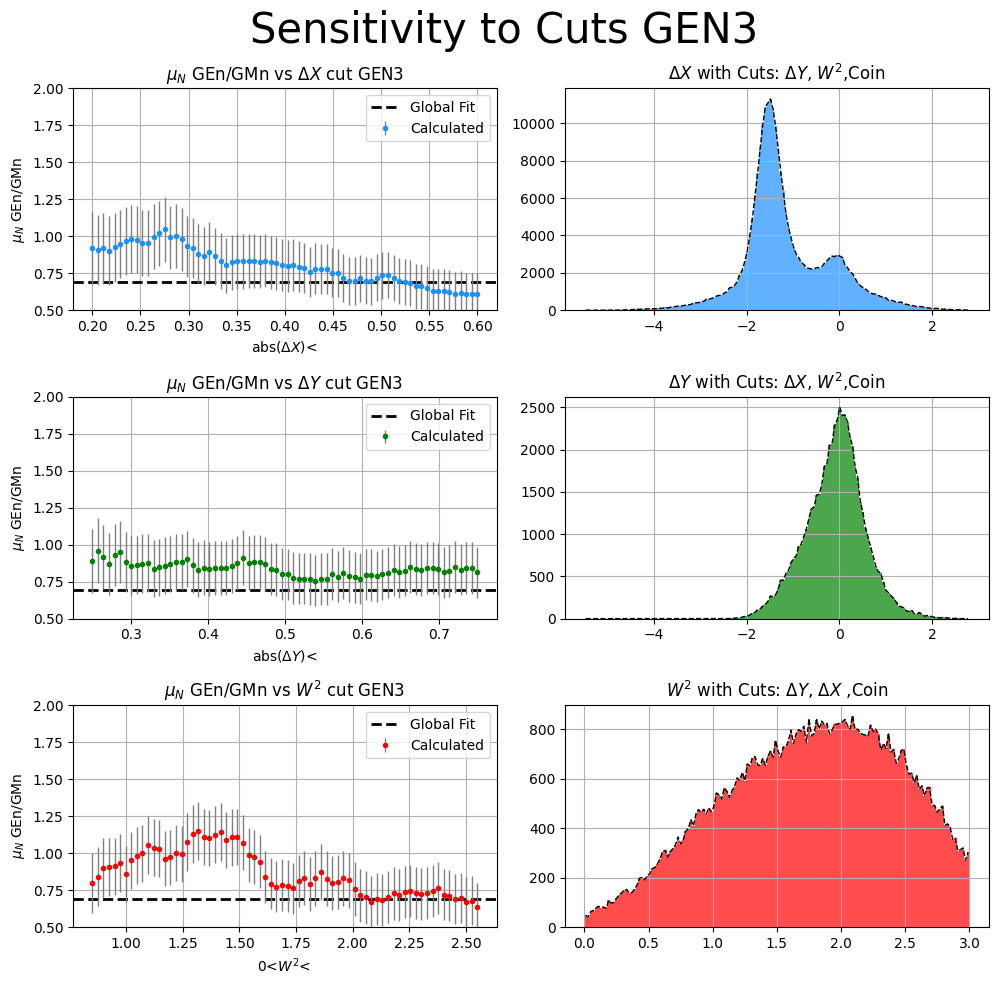

In [120]:
config="3"
lw=1
plt.figure(figsize=(10,10))
plt.suptitle('Sensitivity to Cuts GEN3', fontsize=30)

plt.subplot(3,2,1)
Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')
plt.errorbar(dx_3,muN*abs(R_3dx),muN*abs(RE_3dx),fmt='.',ecolor='grey',color='dodgerblue',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $\Delta X$ cut GEN"+config)
plt.xlabel("abs($\Delta X$)< ")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(.5,2)
plt.grid()
plt.legend(loc="upper right")

plt.subplot(3,2,3)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')

plt.errorbar(dy_3,muN*abs(R_3dy),muN*abs(RE_3dy),fmt='.',ecolor='grey',color='green',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $\Delta Y$ cut GEN"+config)
plt.xlabel("abs($\Delta Y$)<")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(.5,2)
plt.grid()
plt.legend(loc="upper right")

plt.subplot(3,2,5)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')
plt.grid()
plt.errorbar(w2_3,muN*abs(R_3w2),muN*abs(RE_3w2),fmt='.',ecolor='grey',color='red',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $W^2$ cut GEN"+config)
plt.xlabel("0<$W^2$< ")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(.5,2)
plt.legend(loc="upper right")

plt.subplot(3,2,2)
plt.title("$\Delta X$ with Cuts: $\Delta Y$, $W^2$,Coin")
bin_centers,bin_contents=dxHist3
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="dodgerblue",label="$\Delta X$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()
plt.subplot(3,2,4)
plt.title("$\Delta Y$ with Cuts: $\Delta X$, $W^2$,Coin")
bin_centers,bin_contents=dyHist3
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="green",label="$\Delta Y$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()
plt.subplot(3,2,6)
plt.title("$W^2$ with Cuts: $\Delta Y$, $\Delta X$ ,Coin")
bin_centers,bin_contents=w2Hist3
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="red",label="$\Delta Y$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()

plt.tight_layout()
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RAT_allcuts.png")


# GEN4 Plots

In [121]:
config="4"

dxHist4,dyHist4,w2Hist4=Function_MAKEHIST(config)

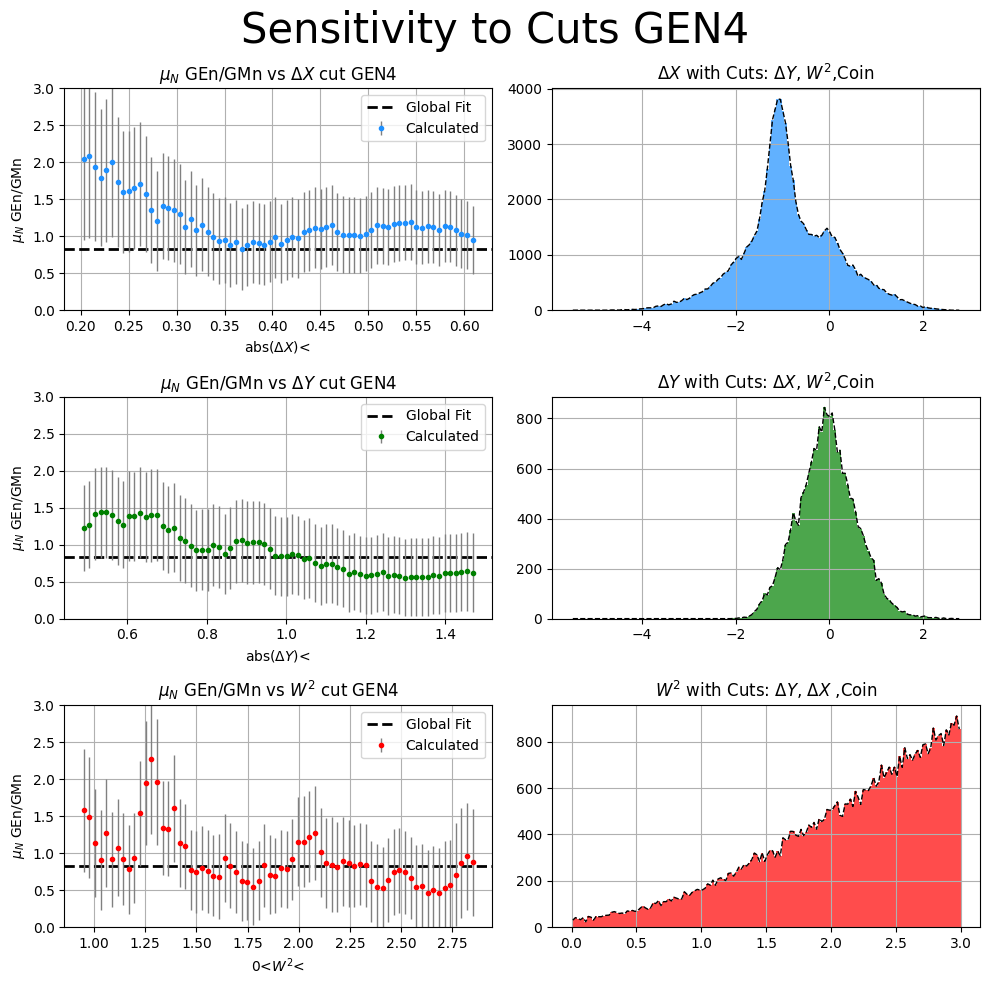

In [122]:
config="4"
lw=1
plt.figure(figsize=(10,10))
plt.suptitle('Sensitivity to Cuts GEN4', fontsize=30)

plt.subplot(3,2,1)
Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
worldDat=CALCULATE.Function_GENWORLDFROMQ2(Q2)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')
plt.errorbar(dx_4,muN*abs(R_4dx),muN*abs(RE_4dx),fmt='.',ecolor='grey',color='dodgerblue',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $\Delta X$ cut GEN"+config)
plt.xlabel("abs($\Delta X$)< ")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(0,3)
plt.grid()
plt.legend(loc="upper right")

plt.subplot(3,2,3)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')

plt.errorbar(dy_4,muN*abs(R_4dy),muN*abs(RE_4dy),fmt='.',ecolor='grey',color='green',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $\Delta Y$ cut GEN"+config)
plt.xlabel("abs($\Delta Y$)<")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(0,3)
plt.grid()
plt.legend(loc="upper right")

plt.subplot(3,2,5)
plt.axhline(y=worldDat, color='black', linestyle='--', linewidth=2,label='Global Fit')
plt.grid()
plt.errorbar(w2_4,muN*abs(R_4w2),muN*abs(RE_4w2),fmt='.',ecolor='grey',color='red',lw=1,label='Calculated')
plt.title("$\mu_N$ GEn/GMn vs $W^2$ cut GEN"+config)
plt.xlabel("0<$W^2$< ")
plt.ylabel('$\mu_N$ GEn/GMn')
plt.ylim(0,3)
plt.legend(loc="upper right")

plt.subplot(3,2,2)
plt.title("$\Delta X$ with Cuts: $\Delta Y$, $W^2$,Coin")
bin_centers,bin_contents=dxHist4
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="dodgerblue",label="$\Delta X$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()
plt.subplot(3,2,4)
plt.title("$\Delta Y$ with Cuts: $\Delta X$, $W^2$,Coin")
bin_centers,bin_contents=dyHist4
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="green",label="$\Delta Y$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()
plt.subplot(3,2,6)
plt.title("$W^2$ with Cuts: $\Delta Y$, $\Delta X$ ,Coin")
bin_centers,bin_contents=w2Hist4
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="red",label="$\Delta Y$")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
plt.grid()

plt.tight_layout()
plt.savefig(f"../plots/CUTSENSITIVITY/GEN{config}/RAT_allcuts.png")
